# Lesson 9: Segmentation

- In the classroom, the libraries are already installed for you.
- If you would like to run this code on your own machine, you can install the following:

```
    !pip install transformers
    !pip install gradio
    !pip install timm
    !pip install torchvision
```

- Here is some code that suppresses warning messages.

In [1]:
from transformers.utils import logging

logging.set_verbosity_error()

### Mask Generation with SAM

The [Segment Anything Model (SAM)](https://segment-anything.com) model was released by Meta AI.

In [2]:
from transformers import pipeline
sam_pipe = pipeline("mask-generation", "Zigeng/SlimSAM-uniform-77")

Info about [Zigeng/SlimSAM-uniform-77](https://huggingface.co/Zigeng/SlimSAM-uniform-77)

In [4]:
from PIL import Image

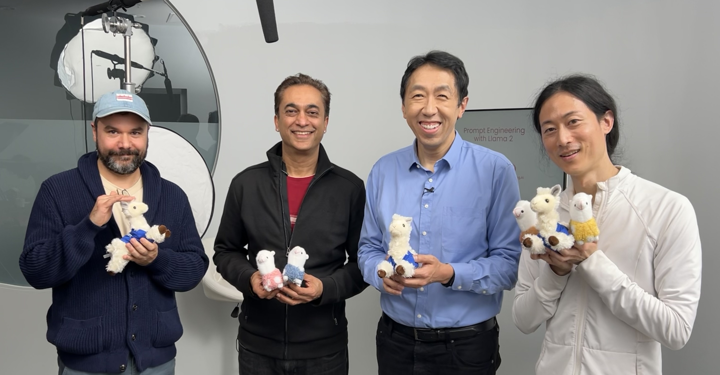

In [5]:
raw_image = Image.open("images/meta_llamas.jpg")
raw_image.resize((720, 375))

- Running this will take some time
- The higher the value of 'points_per_batch', the more efficient pipeline inference will be

In [6]:
output = sam_pipe(raw_image, points_per_batch=32)

In [10]:
output.keys()

dict_keys(['masks', 'scores'])

In [15]:
output["masks"][5].shape

(1500, 2880)

In [16]:
from helper import show_pipe_masks_on_image

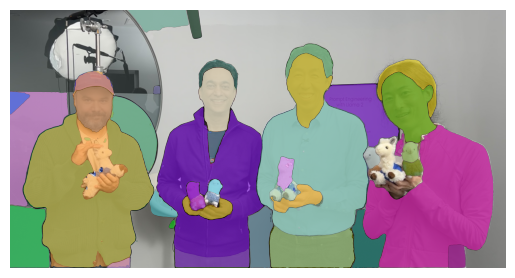

In [17]:
show_pipe_masks_on_image(raw_image, output)

_Note:_ The colors of segmentation, that you will get when running this code, might be different than the ones you see in the video.

### Faster Inference: Infer an Image and a Single Point

In [18]:
from transformers import SamModel, SamProcessor

In [20]:
model = SamModel.from_pretrained("Zigeng/SlimSAM-uniform-77")

processor = SamProcessor.from_pretrained("Zigeng/SlimSAM-uniform-77")

In [21]:
model

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 168, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((168,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=168, out_features=504, bias=True)
          (proj): Linear(in_features=168, out_features=168, bias=True)
        )
        (layer_norm2): LayerNorm((168,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=168, out_features=696, bias=True)
          (lin2): Linear(in_features=696, out_features=168, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(168, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
      (c

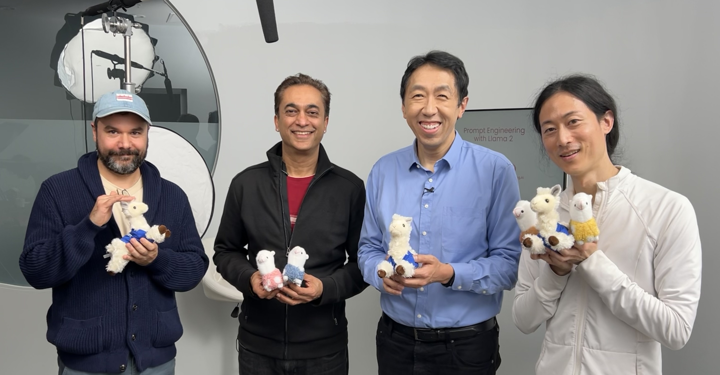

In [22]:
raw_image.resize((720, 375))

- Segment the blue shirt Andrew is wearing.
- Give any single 2D point that would be in that region (blue shirt).

In [23]:
input_points = [[[1600, 700]]]

- Create the input using the image and the single point.
- `return_tensors="pt"` means to return PyTorch Tensors.

In [24]:
inputs = processor(raw_image, input_points=input_points, return_tensors="pt")

- Given the inputs, get the output from the model.

In [26]:
import torch
    
with torch.no_grad():
    outputs = model(**inputs)

In [35]:
outputs.keys()

odict_keys(['iou_scores', 'pred_masks'])

In [27]:
predicted_masks = processor.image_processor.post_process_masks(
    outputs.pred_masks, inputs["original_sizes"], inputs["reshaped_input_sizes"]
)

 Length of `predicted_masks` corresponds to the number of images that are used in the input.

In [28]:
len(predicted_masks)

1

- Inspect the size of the first ([0]) predicted mask

In [30]:
predicted_mask = predicted_masks[0]
predicted_mask.shape

torch.Size([1, 3, 1500, 2880])

In [31]:
outputs.iou_scores

tensor([[[0.9585, 0.9556, 0.9581]]])

In [36]:
from helper import show_mask_on_image

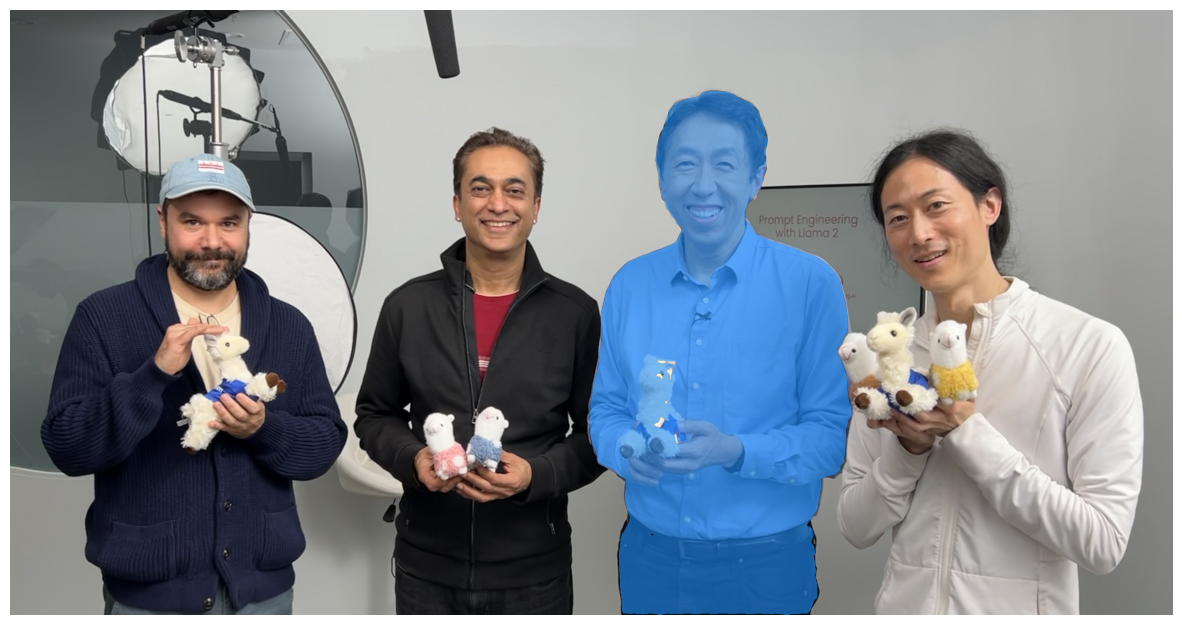

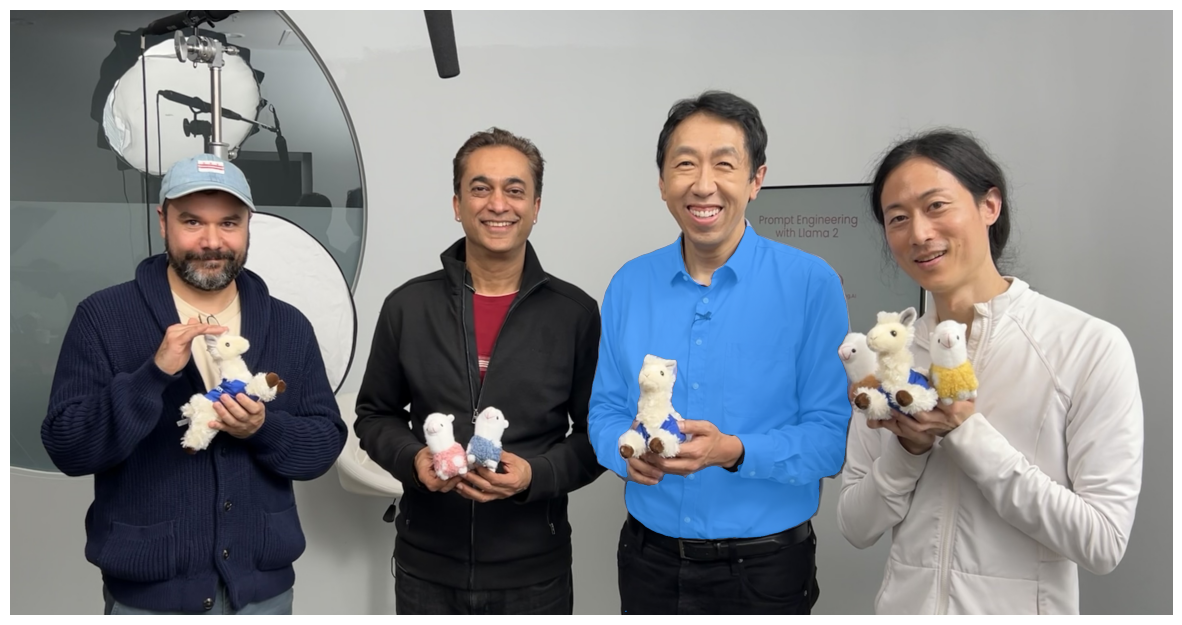

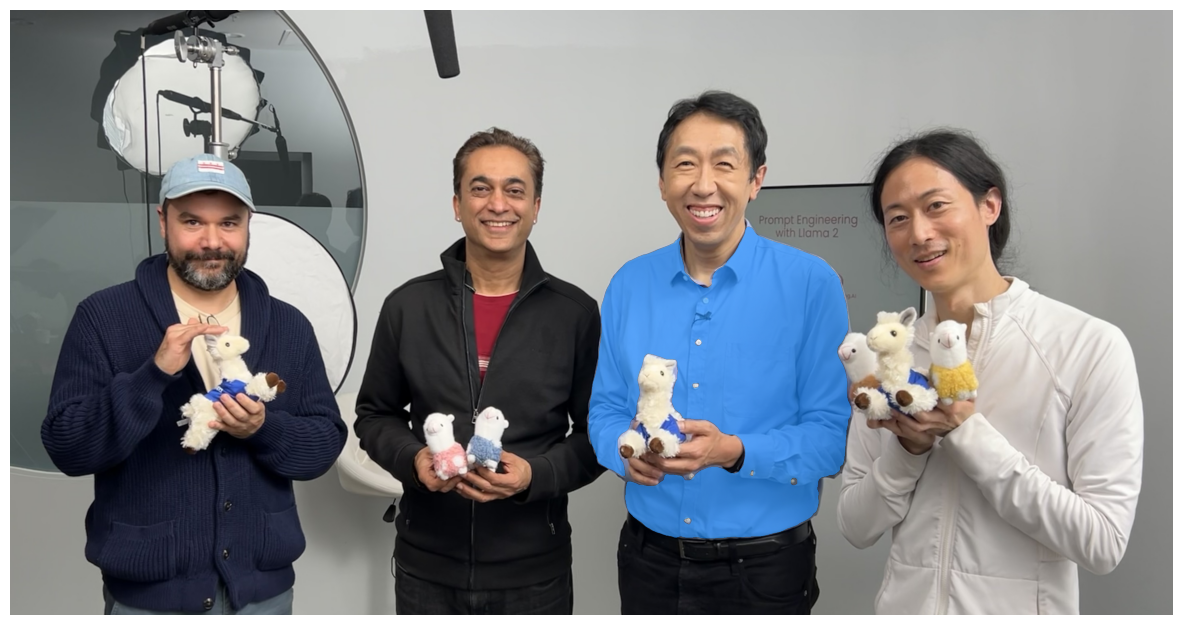

In [37]:
for i in range(3):
    show_mask_on_image(raw_image, predicted_mask[:, i])

## Depth Estimation with DPT

- This model was introduced in the paper [Vision Transformers for Dense Prediction](https://arxiv.org/abs/2103.13413) by Ranftl et al. (2021) and first released in [isl-org/DPT](https://github.com/isl-org/DPT).

In [9]:
import torch
import numpy as np
from PIL import Image


In [8]:
from transformers import pipeline
depth_estimator = pipeline(task="depth-estimation", model="Intel/dpt-hybrid-midas")

Info about ['Intel/dpt-hybrid-midas'](https://huggingface.co/Intel/dpt-hybrid-midas)

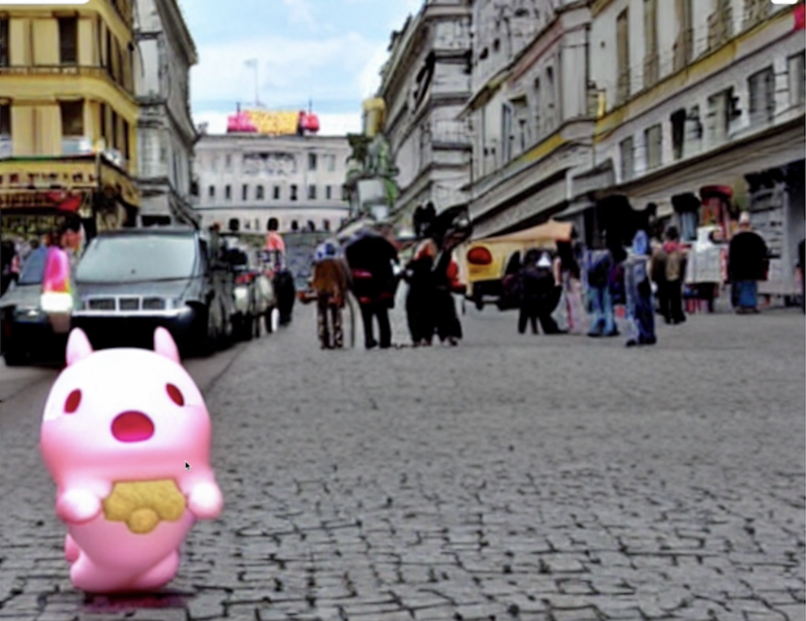

In [40]:
raw_image = Image.open("images/gradio_tamagochi_vienna.png").convert("RGB")
raw_image.resize((806, 621))

- If you'd like to generate this image or something like it, check out the short course on [Gradio](https://www.deeplearning.ai/short-courses/building-generative-ai-applications-with-gradio/) and go to the lesson "Image Generation App".

In [41]:
output = depth_estimator(raw_image)
output

{'predicted_depth': tensor([[[ 248.4071,  252.1830,  256.9171,  ...,  595.8295,  591.8108,
            471.2296],
          [ 247.3372,  254.8538,  257.9681,  ...,  596.0251,  589.0452,
            594.1442],
          [ 259.7675,  259.5482,  261.4168,  ...,  597.6290,  595.3369,
            595.7495],
          ...,
          [3014.1101, 3018.4863, 3019.1729,  ..., 3275.2786, 3269.3469,
           3268.8384],
          [3041.5554, 3040.2788, 3044.4648,  ..., 3280.7490, 3289.3682,
           3274.8716],
          [3039.7500, 3056.0359, 3052.9736,  ..., 3302.0005, 3298.1902,
           3286.9148]]]),
 'depth': <PIL.Image.Image image mode=L size=1612x1242>}

- Post-process the output image to resize it to the size of the original image.

In [56]:
output["predicted_depth"].shape

torch.Size([1, 384, 384])

In [57]:
output["predicted_depth"].unsqueeze(1).shape

torch.Size([1, 1, 384, 384])

In [44]:
prediction = torch.nn.functional.interpolate(
    output["predicted_depth"].unsqueeze(1),
    size=raw_image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

In [45]:
prediction.shape

torch.Size([1, 1, 1242, 1612])

In [46]:
prediction

tensor([[[[ 248.1578,  248.2615,  248.7578,  ...,  468.0627,  447.0035,
            442.8552],
          [ 248.0310,  248.1446,  248.6919,  ...,  477.7615,  458.3929,
            454.5769],
          [ 247.0837,  247.2387,  247.9994,  ...,  508.8534,  494.9499,
            492.2082],
          ...,
          [3040.0396, 3040.3994, 3042.2334,  ..., 3285.1296, 3283.1479,
           3282.7585],
          [3037.8716, 3038.3879, 3041.0298,  ..., 3288.0659, 3286.3372,
           3285.9929],
          [3037.5522, 3038.1150, 3040.9968,  ..., 3289.0708, 3287.3918,
           3287.0562]]]])

- Normalize the predicted tensors (between 0 and 255) so that they can be displayed.

In [48]:
output = prediction.squeeze().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

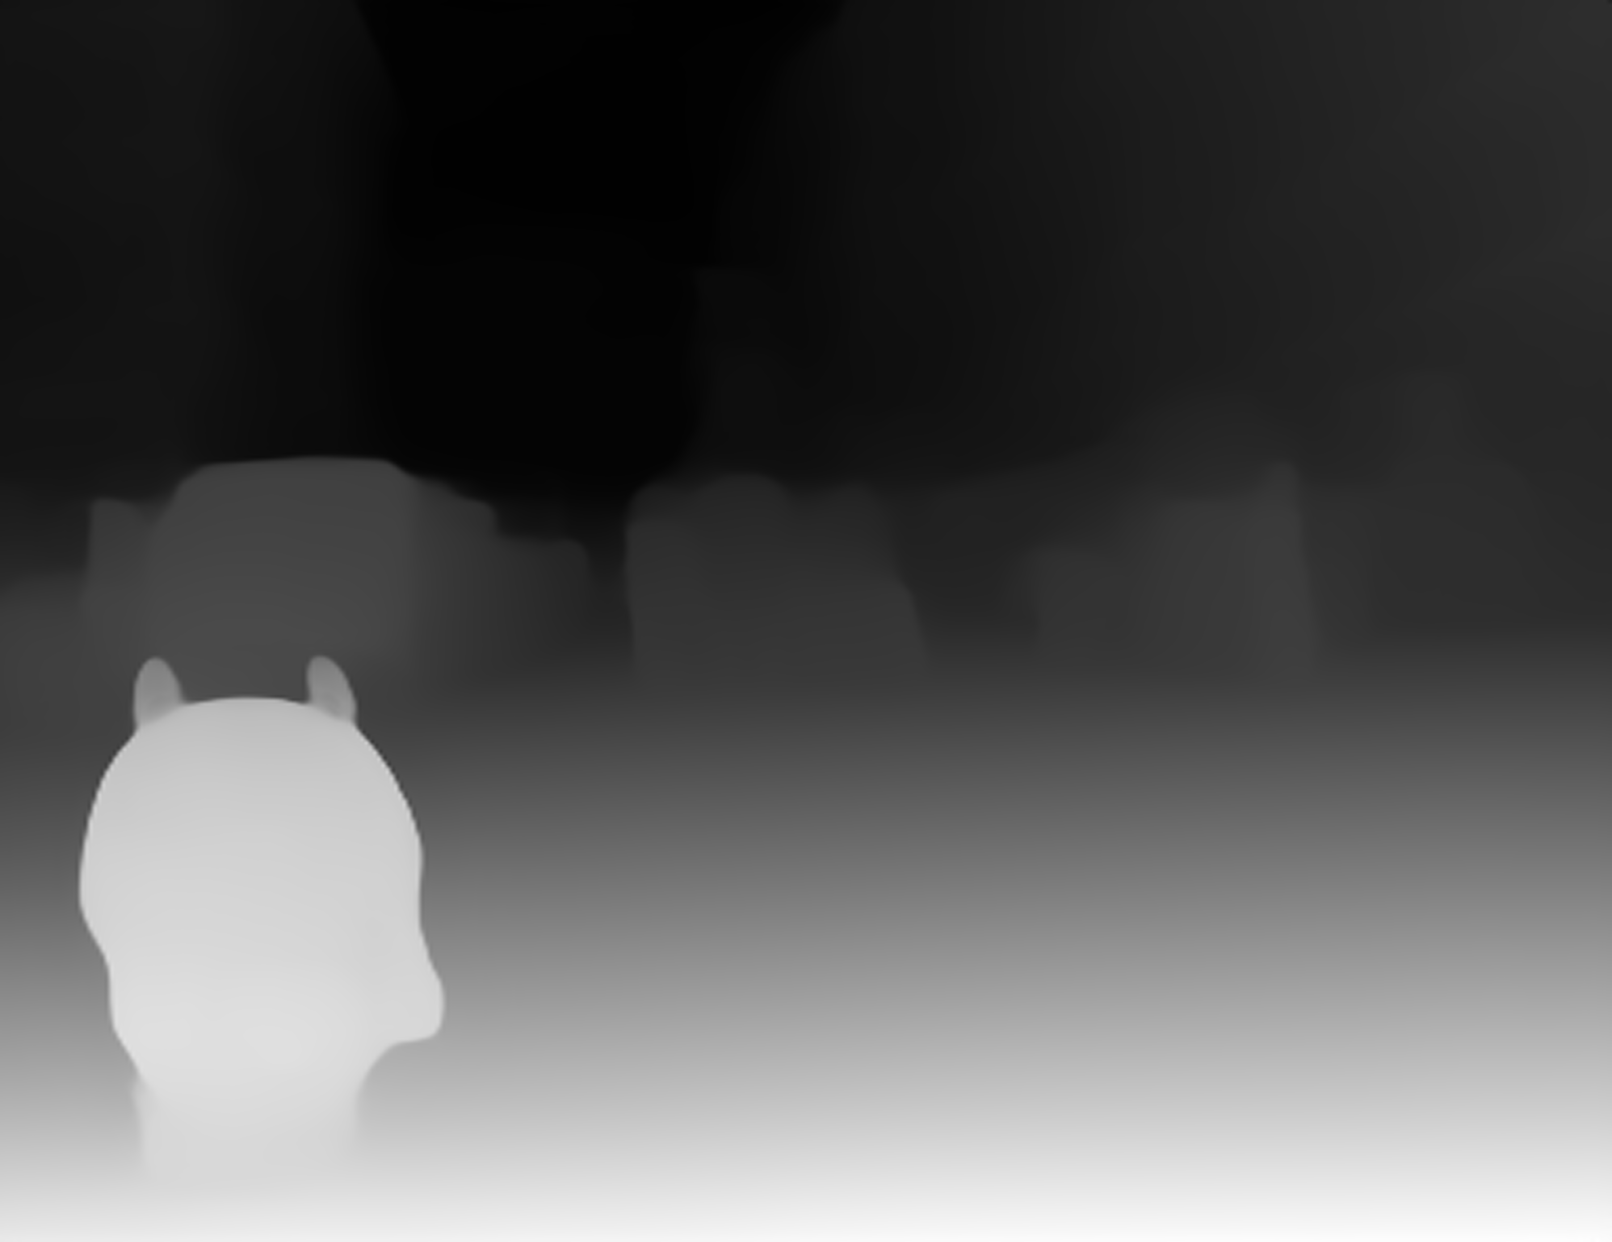

In [49]:
depth

### Demo using Gradio

### Troubleshooting Tip
- Note, in the classroom, you may see the code for creating the Gradio app run indefinitely.
  - This is specific to this classroom environment when it's serving many learners at once, and you won't wouldn't experience this issue if you run this code on your own machine.
- To fix this, please restart the kernel (Menu Kernel->Restart Kernel) and re-run the code in the lab from the beginning of the lesson.

In [11]:
import os
import gradio as gr

In [12]:
def launch(input_image):
    out = depth_estimator(input_image)

    # resize the prediction
    prediction = torch.nn.functional.interpolate(
        out["predicted_depth"].unsqueeze(1),
        size=input_image.size[::-1],
        mode="bicubic",
        align_corners=False,
    )

    # normalize the prediction
    output = prediction.squeeze().numpy()
    formatted = (output * 255 / np.max(output)).astype("uint8")
    depth = Image.fromarray(formatted)
    return depth

In [13]:
iface = gr.Interface(
    launch,
    inputs=gr.Image(label="Input image", type="pil"),
    outputs=gr.Image(label="Output image with predicted instances", type="pil"),
)

In [14]:
iface.launch(share=True, server_port=7860)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://deb68298a4e2deb101.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [15]:
iface.close()

Closing server running on port: 7860


### Close the app
- Remember to call `.close()` on the Gradio app when you're done using it.

### Try it yourself! 
- Try this model with your own images!